# Mastering Scene Understanding: Scene Graphs to the Rescue
## One-Stage Scene Graph Generation
-----


## Clone the RelTR Repository from [Yuren Cong](https://github.com/yrcong/RelTR).

The repository contains the implementation of the paper RelTR: Relation Transformer for Scene Graph Generation (TPAMI2023).

In [1]:
import os
# cloning SSG
if os.path.isdir('RelTR')==False:
    !git clone https://github.com/yrcong/RelTR.git
os.chdir('RelTR')

## Download Visual Genome Dataset

In [2]:
import urllib.request
import zipfile

data_root = "data"
VG_link_1 = ('https://cs.stanford.edu/people/rak248/VG_100K_2/images.zip', 'images.zip')
VG_link_2 = ('https://cs.stanford.edu/people/rak248/VG_100K_2/images2.zip', 'images2.zip')

for link, file in (VG_link_1, VG_link_2):
    data_dir = os.path.join(data_root, "vg/images")
    filename = os.path.join(data_dir, file)
    if not os.path.exists(data_dir):
        if len(data_dir) == 0:
            raise ValueError("data_dir must be a valid path")
        os.makedirs(data_dir)
        urllib.request.urlretrieve(link, filename=filename)

        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        os.remove(filename)


Download the annotations of [VG (in COCO-format)](https://drive.google.com/file/d/1aGwEu392DiECGdvwaYr-LgqGLmWhn8yD/view?usp=sharing) and unzip it in the data/vg.

Compile the code computing box intersection.

In [3]:
%cd lib/fpn/box_intersections_cpu
!python setup.py build_ext --inplace
%cd ../../../

c:\Users\carlo\PycharmProjects\SGG_Tutorial_SIBGRAPI2024\RelTR\lib\fpn\box_intersections_cpu
c:\Users\carlo\PycharmProjects\SGG_Tutorial_SIBGRAPI2024\RelTR


In [4]:
def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=150, type=int)
    parser.add_argument('--lr_drop', default=100, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_entities', default=100, type=int,
                        help="Number of query slots")
    parser.add_argument('--num_triplets', default=200, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    parser.add_argument('--set_iou_threshold', default=0.7, type=float,
                        help="giou box coefficient in the matching cost")

    # * Loss coefficients
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--rel_loss_coef', default=1, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset', default='vg')
    parser.add_argument('--ann_path', default='data/vg/', type=str)
    parser.add_argument('--img_folder', default='data/vg/images/', type=str)

    parser.add_argument('--output_dir', default='output',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=2, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')

    parser.add_argument('--return_interm_layers', action='store_true',
                        help="Return the fpn if there is the tag")
    return parser

In [5]:
import argparse
import datetime
import json
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

parser = argparse.ArgumentParser('RelTR training and evaluation script', parents=[get_args_parser()])
args = parser.parse_args()

if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)

utils.init_distributed_mode(args)
device = torch.device(args.device)

model, criterion, postprocessors = build_model(args)
model.to(device)

model_without_ddp = model
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

param_dicts = [
    {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
    {
        "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
        "lr": args.lr_backbone,
    },
]
optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                weight_decay=args.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)

dataset_train = build_dataset(image_set='train', args=args)
dataset_val = build_dataset(image_set='val', args=args)

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, args.batch_size, drop_last=True)

#Data loaders
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

base_ds = get_coco_api_from_dataset(dataset_val)

output_dir = Path(args.output_dir)

print("Start training")
start_time = time.time()
for epoch in range(args.start_epoch, args.epochs):

    train_stats = train_one_epoch(model, criterion, data_loader_train, optimizer, device, epoch, args.clip_max_norm)
    lr_scheduler.step()
    if args.output_dir:
        checkpoint_paths = [output_dir / 'checkpoint.pth'] # anti-crash
        # extra checkpoint before LR drop and every 100 epochs
        if (epoch + 1) % args.lr_drop == 0 or (epoch + 1) % 5 == 0:
            checkpoint_paths.append(output_dir / f'checkpoint{epoch:04}.pth')
        for checkpoint_path in checkpoint_paths:
            utils.save_on_master({
                'model': model_without_ddp.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'args': args,
            }, checkpoint_path)

    test_stats, coco_evaluator = evaluate(model, criterion, postprocessors, data_loader_val, base_ds, device, args)

    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                    **{f'test_{k}': v for k, v in test_stats.items()},
                    'epoch': epoch,
                    'n_parameters': n_parameters}

    if args.output_dir and utils.is_main_process():
        with (output_dir / "log.txt").open("a") as f:
            f.write(json.dumps(log_stats) + "\n")

        # for evaluation logs
        if coco_evaluator is not None:
            (output_dir / 'eval').mkdir(exist_ok=True)
            if "bbox" in coco_evaluator.coco_eval:
                filenames = ['latest.pth']
                if epoch % 50 == 0:
                    filenames.append(f'{epoch:03}.pth')
                for name in filenames:
                    torch.save(coco_evaluator.coco_eval["bbox"].eval,
                                output_dir / "eval" / name)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

c:\Users\carlo\micromamba\envs\teste4_jSGG\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Not using distributed mode
number of params: 63679528
loading annotations into memory...
Done (t=2.50s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
Start training


c:\Users\carlo\micromamba\envs\teste4_jSGG\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
c:\Users\carlo\micromamba\envs\teste4_jSGG\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Epoch: [0]  [    0/28861]  eta: 3 days, 12:42:54  lr: 0.000100  class_error: 100.00  sub_error: 100.00  obj_error: 88.89  rel_error: 100.00  loss: 98.1448 (98.1448)  loss_ce: 3.2462 (3.2462)  loss_bbox: 6.1638 (6.1638)  loss_giou: 2.6825 (2.6825)  loss_rel: 4.1052 (4.1052)  loss_ce_0: 3.2339 (3.2339)  loss_bbox_0: 6.1090 (6.1090)  loss_giou_0: 2.6908 (2.6908)  loss_rel_0: 4.0955 (4.0955)  loss_ce_1: 3.3873 (3.3873)  loss_bbox_1: 6.1472 (6.1472)  loss_giou_1: 2.7110 (2.7110)  loss_rel_1: 4.1536 (4.1536)  loss_ce_2: 3.4039 (3.4039)  loss_bbox_2: 6.1154 (6.1154)  loss_giou_2: 2.6830 (2.6830)  loss_rel_2: 4.3333 (4.3333)  loss_ce_3: 3.4045 (3.4045)  loss_bbox_3: 6.1782 (6.1782)  loss_giou_3: 2.6817 (2.6817)  loss_rel_3: 4.2371 (4.2371)  loss_ce_4: 3.3189 (3.3189)  loss_bbox_4: 6.1638 (6.1638)  loss_giou_4: 2.6779 (2.6779)  loss_rel_4: 4.2213 (4.2213)  loss_ce_unscaled: 3.2462 (3.2462)  class_error_unscaled: 100.0000 (100.0000)  sub_error_unscaled: 100.0000 (100.0000)  obj_error_unscaled: 8

KeyboardInterrupt: 

## Evaluate with trained checkpoint

In [6]:
checkpoint = torch.load('ckpt/checkpoint0149.pth', map_location='cpu')
model_without_ddp.load_state_dict(checkpoint['model'], strict=True)
# del checkpoint['optimizer']
if not args.eval and 'optimizer' in checkpoint and 'lr_scheduler' in checkpoint and 'epoch' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    args.start_epoch = checkpoint['epoch'] + 1

print('It is the {}th checkpoint'.format(checkpoint['epoch']))
test_stats, coco_evaluator = evaluate(model, criterion, postprocessors, data_loader_val, base_ds, device, args)
if args.output_dir:
    utils.save_on_master(coco_evaluator.coco_eval["bbox"].eval, output_dir / "eval.pth")

It is the 149th checkpoint
Test:  [   0/2500]  eta: 3:31:39  class_error: 38.46  sub_error: 58.06  obj_error: 77.42  rel_error: 80.65  loss: 26.1904 (26.1904)  loss_ce: 0.6508 (0.6508)  loss_bbox: 1.1407 (1.1407)  loss_giou: 1.2376 (1.2376)  loss_rel: 1.3280 (1.3280)  loss_ce_0: 0.6804 (0.6804)  loss_bbox_0: 1.2880 (1.2880)  loss_giou_0: 1.3051 (1.3051)  loss_rel_0: 1.1844 (1.1844)  loss_ce_1: 0.6707 (0.6707)  loss_bbox_1: 1.2267 (1.2267)  loss_giou_1: 1.3035 (1.3035)  loss_rel_1: 1.2043 (1.2043)  loss_ce_2: 0.6303 (0.6303)  loss_bbox_2: 1.2257 (1.2257)  loss_giou_2: 1.2774 (1.2774)  loss_rel_2: 1.2285 (1.2285)  loss_ce_3: 0.6541 (0.6541)  loss_bbox_3: 1.1393 (1.1393)  loss_giou_3: 1.2425 (1.2425)  loss_rel_3: 1.2761 (1.2761)  loss_ce_4: 0.6414 (0.6414)  loss_bbox_4: 1.1611 (1.1611)  loss_giou_4: 1.2425 (1.2425)  loss_rel_4: 1.2513 (1.2513)  loss_ce_unscaled: 0.6508 (0.6508)  class_error_unscaled: 38.4615 (38.4615)  sub_error_unscaled: 58.0645 (58.0645)  obj_error_unscaled: 77.4194 (77

## Run inference on any image

VG 150 enitiy classes and 50 relationship classes.


In [7]:
CLASSES = [ 'N/A', 'airplane', 'animal', 'arm', 'bag', 'banana', 'basket', 'beach', 'bear', 'bed', 'bench', 'bike',
                'bird', 'board', 'boat', 'book', 'boot', 'bottle', 'bowl', 'box', 'boy', 'branch', 'building',
                'bus', 'cabinet', 'cap', 'car', 'cat', 'chair', 'child', 'clock', 'coat', 'counter', 'cow', 'cup',
                'curtain', 'desk', 'dog', 'door', 'drawer', 'ear', 'elephant', 'engine', 'eye', 'face', 'fence',
                'finger', 'flag', 'flower', 'food', 'fork', 'fruit', 'giraffe', 'girl', 'glass', 'glove', 'guy',
                'hair', 'hand', 'handle', 'hat', 'head', 'helmet', 'hill', 'horse', 'house', 'jacket', 'jean',
                'kid', 'kite', 'lady', 'lamp', 'laptop', 'leaf', 'leg', 'letter', 'light', 'logo', 'man', 'men',
                'motorcycle', 'mountain', 'mouth', 'neck', 'nose', 'number', 'orange', 'pant', 'paper', 'paw',
                'people', 'person', 'phone', 'pillow', 'pizza', 'plane', 'plant', 'plate', 'player', 'pole', 'post',
                'pot', 'racket', 'railing', 'rock', 'roof', 'room', 'screen', 'seat', 'sheep', 'shelf', 'shirt',
                'shoe', 'short', 'sidewalk', 'sign', 'sink', 'skateboard', 'ski', 'skier', 'sneaker', 'snow',
                'sock', 'stand', 'street', 'surfboard', 'table', 'tail', 'tie', 'tile', 'tire', 'toilet', 'towel',
                'tower', 'track', 'train', 'tree', 'truck', 'trunk', 'umbrella', 'vase', 'vegetable', 'vehicle',
                'wave', 'wheel', 'window', 'windshield', 'wing', 'wire', 'woman', 'zebra']

REL_CLASSES = ['__background__', 'above', 'across', 'against', 'along', 'and', 'at', 'attached to', 'behind',
                'belonging to', 'between', 'carrying', 'covered in', 'covering', 'eating', 'flying in', 'for',
                'from', 'growing on', 'hanging from', 'has', 'holding', 'in', 'in front of', 'laying on',
                'looking at', 'lying on', 'made of', 'mounted on', 'near', 'of', 'on', 'on back of', 'over',
                'painted on', 'parked on', 'part of', 'playing', 'riding', 'says', 'sitting on', 'standing on',
                'to', 'under', 'using', 'walking in', 'walking on', 'watching', 'wearing', 'wears', 'with']

## Build and load the pretrained model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import requests
import matplotlib.pyplot as plt

from models.backbone import Backbone, Joiner
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from models.reltr import RelTR

position_embedding = PositionEmbeddingSine(128, normalize=True)
backbone = Backbone('resnet50', False, False, False)
backbone = Joiner(backbone, position_embedding)
backbone.num_channels = 2048

transformer = Transformer(d_model=256, dropout=0.1, nhead=8,
                          dim_feedforward=2048,
                          num_encoder_layers=6,
                          num_decoder_layers=6,
                          normalize_before=False,
                          return_intermediate_dec=True)

model = RelTR(backbone, transformer, num_classes=151, num_rel_classes = 51,
              num_entities=100, num_triplets=200)

# The checkpoint is pretrained on Visual Genome
#ckpt = torch.hub.load_state_dict_from_url(
#    url='https://cloud.tnt.uni-hannover.de/index.php/s/PB8xTKspKZF7fyK/download/checkpoint0149.pth', map_location='cpu', check_hash=True) #The URL is not working anymore
ckpt = torch.load('ckpt/checkpoint0149.pth', map_location=torch.device('cpu'))
model.load_state_dict(ckpt['model'])
model.eval()


RelTR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_

In [10]:
# Some transformation functions
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
          (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

## Load an example image

You can replace the link with other images. Note that the entities in the used image should be included in the VG labels.

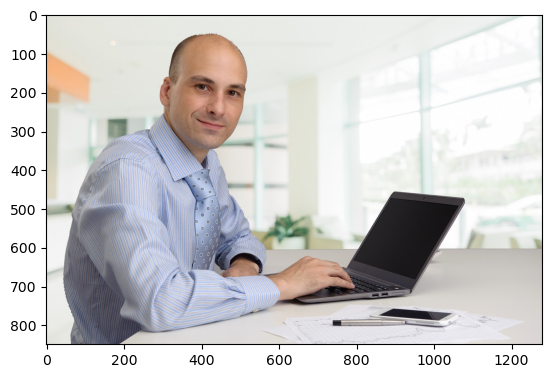

In [11]:
url = 'https://cdn.pixabay.com/photo/2021/04/26/09/30/man-6208470_1280.jpg'
im = Image.open(requests.get(url, stream=True).raw)
plt.imshow(im)
img = transform(im).unsqueeze(0)

## Perform inference using the provided image

In [12]:
# propagate through the model
outputs = model(img)

# keep only predictions with >0.3 confidence
probas = outputs['rel_logits'].softmax(-1)[0, :, :-1]
probas_sub = outputs['sub_logits'].softmax(-1)[0, :, :-1]
probas_obj = outputs['obj_logits'].softmax(-1)[0, :, :-1]
keep = torch.logical_and(probas.max(-1).values > 0.3, torch.logical_and(probas_sub.max(-1).values > 0.3,
                                                                        probas_obj.max(-1).values > 0.3))

In [13]:
# convert boxes from [0; 1] to image scales
sub_bboxes_scaled = rescale_bboxes(outputs['sub_boxes'][0, keep], im.size)
obj_bboxes_scaled = rescale_bboxes(outputs['obj_boxes'][0, keep], im.size)

topk = 10 # display up to 10 images
keep_queries = torch.nonzero(keep, as_tuple=True)[0]
indices = torch.argsort(-probas[keep_queries].max(-1)[0] * probas_sub[keep_queries].max(-1)[0] * probas_obj[keep_queries].max(-1)[0])[:topk]
keep_queries = keep_queries[indices]

In [14]:
# save the attention weights
conv_features, dec_attn_weights_sub, dec_attn_weights_obj = [], [], []
hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.decoder.layers[-1].cross_attn_sub.register_forward_hook(
        lambda self, input, output: dec_attn_weights_sub.append(output[1])
    ),
    model.transformer.decoder.layers[-1].cross_attn_obj.register_forward_hook(
        lambda self, input, output: dec_attn_weights_obj.append(output[1])
    )]

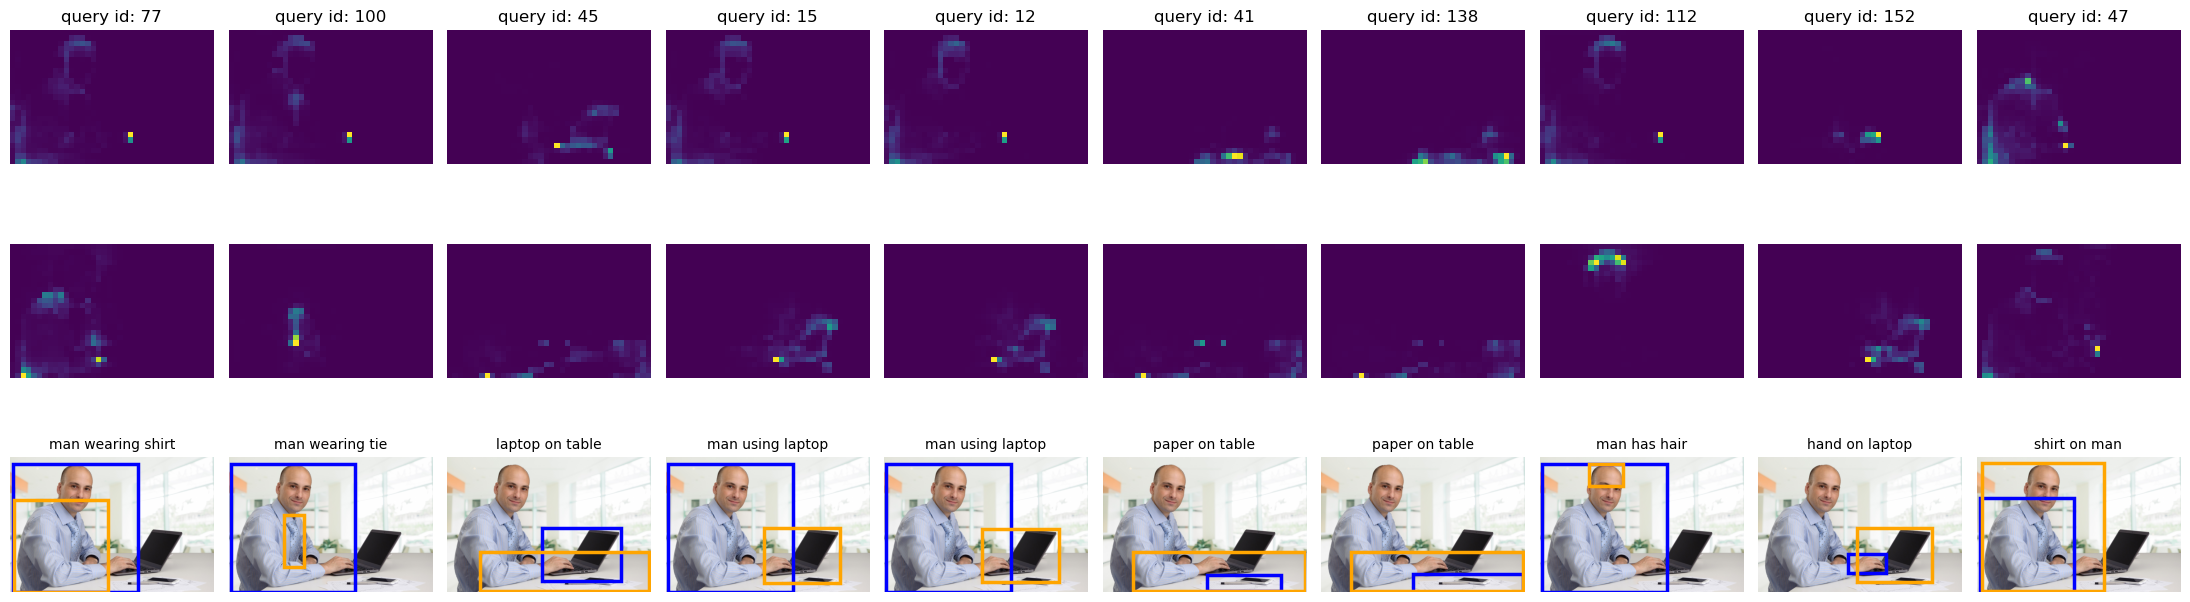

In [15]:
with torch.no_grad():
    # propagate through the model
    outputs = model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    dec_attn_weights_sub = dec_attn_weights_sub[0]
    dec_attn_weights_obj = dec_attn_weights_obj[0]

    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]
    im_w, im_h = im.size

    fig, axs = plt.subplots(ncols=len(indices), nrows=3, figsize=(22, 7))
    for idx, ax_i, (sxmin, symin, sxmax, symax), (oxmin, oymin, oxmax, oymax) in \
            zip(keep_queries, axs.T, sub_bboxes_scaled[indices], obj_bboxes_scaled[indices]):
        ax = ax_i[0]
        ax.imshow(dec_attn_weights_sub[0, idx].view(h, w))
        ax.axis('off')
        ax.set_title(f'query id: {idx.item()}')
        ax = ax_i[1]
        ax.imshow(dec_attn_weights_obj[0, idx].view(h, w))
        ax.axis('off')
        ax = ax_i[2]
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((sxmin, symin), sxmax - sxmin, symax - symin,
                                    fill=False, color='blue', linewidth=2.5))
        ax.add_patch(plt.Rectangle((oxmin, oymin), oxmax - oxmin, oymax - oymin,
                                    fill=False, color='orange', linewidth=2.5))

        ax.axis('off')
        ax.set_title(CLASSES[probas_sub[idx].argmax()]+' '+REL_CLASSES[probas[idx].argmax()]+' '+CLASSES[probas_obj[idx].argmax()], fontsize=10)

    fig.tight_layout()
    plt.show() # show the output
